<h1>Contents</h1>

<ul> 
    <li> <a href="#Visualize">Visualize training samples. </a>
    <ul> 
        <li> <a href="#healty_samples">Healthy samples. </a> </li>
        <li> <a href="#Multiple_diseases_samples">Multiple diseases samples. </a> </li>
        <li> <a href="#rust_samples">Rust samples. </a> </li>
        <li> <a href="#scab_samples">Scab samples. </a> </li>       
   </ul>     
</li>
     <li> <a href="#augment0">Image augmentation.</a>
    <ul> 
        <li> <a href="#shift_augment">Shifting images.</a> </li>
        <li> <a href="#Rotating">Rotating images.</a> </li>
        <li> <a href="#flip_augment">Flipping images.</a> </li>
        <li> <a href="#augment">Total conditions of image Augmentation </a> </li>       
        </ul>
   </li>    
    <li> <a href="#train_data">Load training data. </a></li>   
    <li> <a href="#training">Training</a>
    <ul> 
        <li> <a href="#Google_Net_Archeticture">GoogLeNet Archeticture</a> </li>
        <li> <a href="#GoogLeNet_network_with_all_the_bells_and_whistles">GoogLeNet network with all the bells and whistles</a> </li>
        <li> <a href="#implementing_inception">Implementing inception block.</a> </li>       
        <li> <a href="#Inception_architecture">GoogLeNet incarnation of the Inception architecture.</a> </li>
        <li> <a href="#Aux_network">Auxiliary Network.</a> </li>
        <li> <a href="#implement_G_NN">Implement GoogLeNet.</a> </li>
        <li> <a href="#train_google_NN">Training GoogLeNet model.</a> </li>
        <li> <a href="#plt_aux0">Plotting Auxiliary Network 0 accuracy and loss function during training.</a> </li>
        <li> <a href="#plt_aux1">Plotting Auxiliary Network 1 accuracy and loss function during training.</a> </li>
        <li> <a href="#plt_main">Plotting Main Network accuracy and loss function during training.</a> </li>
        <br>
        <li> <a href="#resnet">Resnet.</a> </li>
        <li> <a href="#skip_connection">Skip Connection.</a> </li>
        <li> <a href="#arc_table">Architecture table for building block.</a> </li>
        <li> <a href="#resnet_implementation">Resnet implementation.</a> </li>
        <li> <a href="#resnet_training">Resnet training.</a> </li>
        <li> <a href="#resnet_trainingplt">Plotting resnet during training.</a> </li>
        </ul>
   </li>
    <br>
    <li> <a href="#load_prediction">Load prediction data.</a> </li>
    <li> <a href="#prediction_google">GoogLeNet prediction.</a> </li>
    <li> <a href="#prediction_resnet">ResNet prediction.</a> </li>
    <li> <a href="#ensemble">Ensemble.</a> </li>
    </ul>
    

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical,plot_model
from sklearn.model_selection import train_test_split

In [ ]:
train_class = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test_class = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
train_class.head()

Checking for unbalanced classes.

Count samples of each class for training data

In [ ]:
healthy_class = train_class['healthy'].value_counts()[1]
multipleDiseases_class = train_class['multiple_diseases'].value_counts()[1]
rust_class = train_class['rust'].value_counts()[1]
scab_class = train_class['scab'].value_counts()[1]

print('Healthy :: number of samples is ', healthy_class)
print('Multiple Diseases :: number of samples is ', multipleDiseases_class)
print('Rust :: number of samples is ', rust_class)
print('Scab :: number of samples is ', scab_class)

plt.pie([healthy_class,multipleDiseases_class,rust_class,scab_class], 
        labels=('Healthy','Multiple Diseases','Rust','Scab'),autopct='%1.1f%%')
plt.axis('equal')
plt.show()

<p style="color:red; font-size:125%;" >We deduce that Multiple Diseases class has very low samples with respect to other classes, so we should increase it by data augmentation.</p>


Checking for training images size.

In [ ]:
img_size = []
main_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images'
path_list = os.listdir(main_dir) #include paths for training samples
for file in path_list:
  img = cv2.imread(f'{main_dir}/{file}')
  img_size.append(img.shape)
img_size = pd.Series(img_size)
img_size.value_counts()

<p style="color:blue; font-size:125%" >  We found that 22 sample has diffrent orientation so We should adjust orientation while loading training data</p>

<p id ="Visualize" style="font-size:150%"> Visualize training samples</p>

In [ ]:
def visualize_trainSamples(*,sample_class,numberofSamples ):
    global train_class
    sample = list()
    for i in range(0, len(train_class)):
        if list(train_class.iloc[i][1:]) == sample_class:
          sample.append(i)
        if len(sample) == numberofSamples: break      
    fig, ax = plt.subplots(nrows=numberofSamples//2, ncols=numberofSamples//2, figsize=(25, 25))
    for j in range(numberofSamples//2):
      for k in range(numberofSamples//2):
        img = cv2.imread(f'{main_dir}/Train_{sample[j+k]}.jpg')
        ax[j][k].imshow(img)
    


<p id ="healty_samples" style="font-size:125%"> Visualize samples of healthy.</p>

In [ ]:
visualize_trainSamples(sample_class=[1,0,0,0], numberofSamples=8)

<p id ="Multiple_diseases_samples" style="font-size:125%"> Visualize samples of Multiple diseases.</p>

In [ ]:
visualize_trainSamples(sample_class=[0,1,0,0], numberofSamples=8)

<p id ="rust_samples" style="font-size:125%"> Visualize samples of rust.</p>

In [ ]:
visualize_trainSamples(sample_class=[0,0,1,0], numberofSamples=8)

<p id ="scab_samples" style="font-size:125%">Visualize samples of scab.</p>

In [ ]:
visualize_trainSamples(sample_class=[0,0,0,1], numberofSamples=8)

<p id ="augment0" style="font-size:150%">Image augmentation</p>

<p style = "font-size:125%">
Image augmentation Is a common technique to increase training dataset samples by artificially creating images which are artificially exposed to diffrent conditions such as rotation, flipping, noise etc

</p>


<p>
    <p id ="shift_augment" style="font-size:125%">Shifting images.</p>
    
<br>    
<br>
Shifting image means applying transition matric to image
<br>
    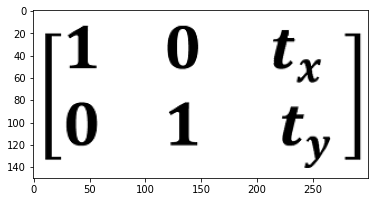
    <br>
where:
<br>
tx is the value of transition in X-axis (columns)
<br>
ty is the value of transition in X-axis (rows)
</p>

In [ ]:
rand_imagePath = random.choice(path_list) # read random image from data set
rand_image = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/'+rand_imagePath)
rand_image = cv2.cvtColor(rand_image, cv2.COLOR_BGR2RGB) #opencv read image at BGR color space, so it was converted to RGB inorder to display with matplotlib
cols, rows = rand_image.shape[1], rand_image.shape[0]
#get random value in x axis and y axis to shift
tx = random.randint(-500, 500)
ty = random.randint(-500, 500)
M = np.float32([[1, 0, tx], [0, 1, ty]]) #transition matrix
rand_image_augTranslation = cv2.warpAffine(rand_image, M, (cols, rows)) #apply transition matric
#show diffrence before and after shifting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
ax[0].imshow(rand_image)
ax[1].imshow(rand_image_augTranslation)


Remove crop image to remove black region
<p>
to determine the boundary for correct region
<br>
x is the value of tx if tx is positive otherwise it would be zero
<br>
y is the value of ty if ty is positive otherwise it would be zero
</p>


In [ ]:
x, y = max(tx, 0), max(ty, 0)
w, h = cols - abs(tx), rows - abs(ty)
rand_image_augTranslation = rand_image_augTranslation[y:y+h, x:x+w] 
rand_image_augTranslation = cv2.resize(rand_image_augTranslation, (cols, rows))
plt.imshow(rand_image_augTranslation)

<p id ="Rotating" style="font-size:125%">Rotating Augmentation</p>

Rotation It 's defined by applying rotation matrix to image.
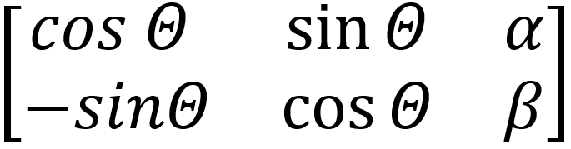
<p>
α = (1-Cos(Θ))Cx - Sin(Θ)Cy
<br>
β = sin(Θ)Cx + (1-Cos(Θ)) Cy
<br>
<br>
Where Cx is the center of rotation in x-axis.
<br>
Cy is the center of rotation in y-axis.
<br>
openCV calculate this rotation matrix by using cv2.getRotationMatrix2D((Cx, Cy),angle ,1) # center of rotation , angle , scale
</p>

<p id ="flip_augment" style="font-size:125%">Flipping Augmentation</p>



<p>
Flipping image opencv flips a 2d array by function output_image = cv2.flip(input_image, flipCode)
<br>
As shown at next figure flip code when passed as a number
<br>
greater than 0 flip about y-axis in otherwords horizontal flipping
<br>
equal 0 flip about x-axis in other words vertical flipping
<br>
smaller than 0 about x-axis and y-axis
<br>
    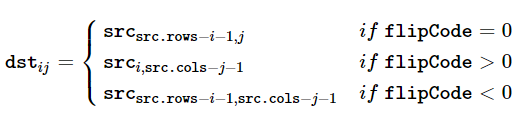
</p>

In [ ]:
rand_imagePath = random.choice(path_list) # read random image from data set
rand_image = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/'+rand_imagePath)
rand_image = cv2.cvtColor(rand_image, cv2.COLOR_BGR2RGB) #opencv read image at BGR color space, so it was converted to RGB inorder to display with matplotlib
cols, rows = rand_image.shape[1], rand_image.shape[0]
rand_image_augTranslation = cv2.flip(rand_image,random.randint(-1, 1)) 
#show diffrence before and after flipping
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
ax[0].imshow(rand_image)
ax[1].imshow(rand_image_augTranslation)


<p id ="augment" style="font-size:150%">Image Augmentation</p>

In [ ]:
def augmentImage(image,*, shifting=(-100, 100),bluring=(10, 10), angle=(-30, 30)):
  image = cv2.resize(image,(640, 480))
  cols, rows = image.shape[1], image.shape[0]
  #random bluring image.
  bluring_value = random.randint(*bluring)
  if bluring_value % 2 ==0:
    bluring_value-=1

  #random cropping image
  tx = random.randint(*shifting) #cropping value at x-axis.
  ty = random.randint(*shifting) #cropping value at y-axis.

  M = np.float32([[1, 0, tx], [0, 1, ty]]) #transition matrix.
  image = cv2.warpAffine(image, M, (cols, rows))
  x, y = max(tx, 0), max(ty, 0)
  w, h = cols - abs(tx), rows - abs(ty)
  image = image[y:y+h, x:x+w] 
  image = cv2.resize(image, (cols, rows))
  #Random rotating image

  M = cv2.getRotationMatrix2D((cols/2, rows/2),random.randint(*angle) ,1) #Rotation matrix
  image = cv2.warpAffine(image, M, (cols, rows))  
  # random flipping image
  image = cv2.flip(image,random.randint(-1, 1)) 
  return image
#choose any random image to visualise sample of augmented image.
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for j in range(4):
    for k in range(4):
        rand_imagePath = random.choice(path_list)
        rand_image = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/'+rand_imagePath)
        rand_image = cv2.cvtColor(rand_image, cv2.COLOR_BGR2RGB)
        ax[j][k].imshow(augmentImage(rand_image))


[More details about image augmentation using openCV explained at this notebook](https://www.kaggle.com/ahmedabdelfattah20/image-augmentation-using-opencv)

<p id ="train_data" style="font-size:150%">Load data</p>

In [ ]:
X_train, y_train = list(), list() 
def getIndex(file_name): #get index of image to find corresponsing class at CSV sheet.
  '''
  for example file name is
  Train_163.jpg
  We want to get number 163
  We shoud search for _ index 
  so index of first slice is _ + 1
  then seach for .
  so index of second slice is _ + 1
  '''
  first_slice = file_name.find('_')+1
  second_slice = file_name.find('.')
  index = int(file_name[first_slice:second_slice])
  return index

for file in path_list:
  img = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images' + '/'+ file)  
  if img.shape[0] > img.shape[1]: #there is 22 image have diffrent orientation as mentioned above, so it should be rotated by 90 deg.
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  img = cv2.resize(img, (640, 480))  
  index = getIndex(file)
  if file[0:5] == 'Train':
    img_class_categorical = list(train_class.iloc[index][1:5])
    X_train.append(img)
    y_train.append(img_class_categorical)
#split validation and test data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.17, random_state=44, shuffle=True)
X_val = np.array(X_val).astype('float32')/255.0
y_val = np.array(y_val,dtype=np.float32)


Apply data augmentation to traing data set.

In [ ]:
X_augmented = [] #temporary store X_augmented images
y_augmented = [] ##temporary store corresponding class to X_augmented images

for index, img in enumerate(X_train):
  repetition = 5
  if y_train[index] == [0, 1, 0, 0]:
    repetition *=6  #to balance multiple diseases class
  for i in range(repetition):
    image = augmentImage(img)
    image = cv2.imencode('.jpg', image)[1] #encode image to reduce stored size at memory
    X_augmented.append(image)
    y_augmented.append(y_train[index])
  X_train[index] =  cv2.imencode('.jpg', X_train[index])[1]

X_train += X_augmented
y_train += y_augmented
del(X_augmented)
del(y_augmented)


Help functions during training

In [ ]:
def shuffle_data(x, y): #to shuffle training data before each epoch
  tmp = list(zip(x, y)) 
  random.shuffle(tmp)
  x, y = zip(*tmp)
  x, y = list(x), list(y)
  del(tmp)
  return x, y

def plot(label, *args): # plotting Accuracy and loos for each model
  plt.style.use('ggplot')
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,15))
  for i in range(2):
    ax[i].plot(range(1,len(args[i][0])+1), args[i][0],'r',label='Train')
    ax[i].plot(range(1,len(args[i][1])+1), args[i][1],'b',label='Validation')
    ax[i].set_xlabel('Epochs')
    if i == 0 : ax[i].set_ylabel(label+ ' Loss')
    else : ax[i].set_ylabel(label+ ' Accuracy')
    ax[i].legend()  
  plt.grid('true')
  plt.show()

def deCode(img):#decode img
  img = np.frombuffer(img, dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_UNCHANGED)
  return img
#load data to model while training
def dataGenerator(multiple_output=False):    
  global X_train, y_train, batch_size
  steps = len(X_train)//batch_size+1 #number of steps per one epoch.
  while True:
    X_train, y_train = shuffle_data(X_train, y_train) # shuffle data before each epoch.
    for i in range(steps):
      img = X_train[i*batch_size: (i+1)*batch_size] #load image ber step
      img = list(map(deCode, img))
      img_y = y_train[i*batch_size: (i+1)*batch_size]
      img = np.array(img)
      img = img.astype('float32')/255
      img_y = np.array(img_y, dtype=np.float32)
      if multiple_output == True : #used only at inception architecture model
        yield (img, [img_y,img_y, img_y ])
      else :
        yield (img, img_y)

'''
save_bestWeights class is used to save best weights for model while training
for example
when passing 'val_accuracy' to constructor it will save the weights of highest accuracy of validation.
or  passing 'loss' to constructor it will save the weights of lowest loss of training.
also valid for 'loss_acc' or 'val_accuracy'
when you pass a key it checks if it contain 'loss' to save lowest property
if it contain 'acc' to save best property.
'''
class save_bestWeights(Callback): # save best model weights
  def __init__(self, key):
    self.__loss = float('inf') #initialize with highest value to find the lowest values. 
    self.__acc = 0 #initialize with zero value to find the best values.
    self.__weights = None #weights of model
    self.__log = dict()
    self.__key = key
    if self.__key.find('loss') != -1: #check to seact for highest or lowest property based on loss and acc.
        self.__state = 'loss'
    else: 
        self.__state = 'acc'     
  def on_epoch_end(self, epoch, logs=None): 
    if (self.__state == 'loss') and (logs[self.__key] < self.__loss):
      self.__loss = logs[self.__key]
      self.__weights = self.model.get_weights()
      self.__log = logs
    if (self.__state == 'acc') and (logs[self.__key] > self.__acc):
      self.__acc = logs[self.__key]
      self.__weights = self.model.get_weights()
      self.__log = logs    

  def get_bestWeights(self):
    return self.__weights
  def get_log(self):
    return self.__log


<p id ="training" style="font-size:200%">Training</p>

googleLenet and Resnet50 archeticture will be implemented then ensemble the output of both models.


<p id ="Google_Net_Archeticture" style="font-size:200%">Google Net Archeticture</p>
<p>
It was proposed in the ImageNet Large-Scale Visual Recognition Challenge 2014 and applies Hebbian principle to optimize quality.
<br>
Usually increasing size of neural-network increases the performance but there is a limit when exceeding this limit, the problem of vanishing gradient would arise this leading to over-fitting.
<br>
It focused on increasing the depth and width of the network with the same Computational power by applying idea of sparsely connected architecture.
  <br><br>
    [GoogLeNet paper](https://arxiv.org/abs/1409.4842)
    
</p>

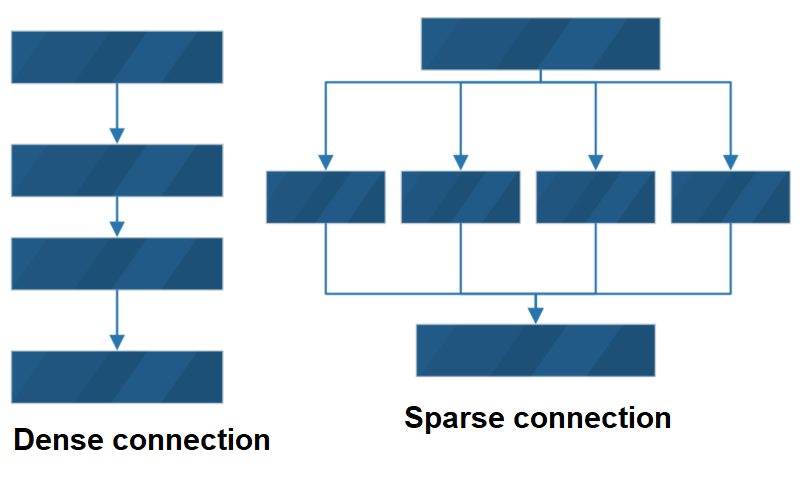

<p id ="GoogLeNet_network_with_all_the_bells_and_whistles" style="font-size:200%">GoogLeNet network with all the bells and whistles</p>

<p style = 'font-size:125%'>GoogLeNet has two auxiliary clasffifiers and
losses of the auxiliary classifiers
are weighted by 0.3. </p>

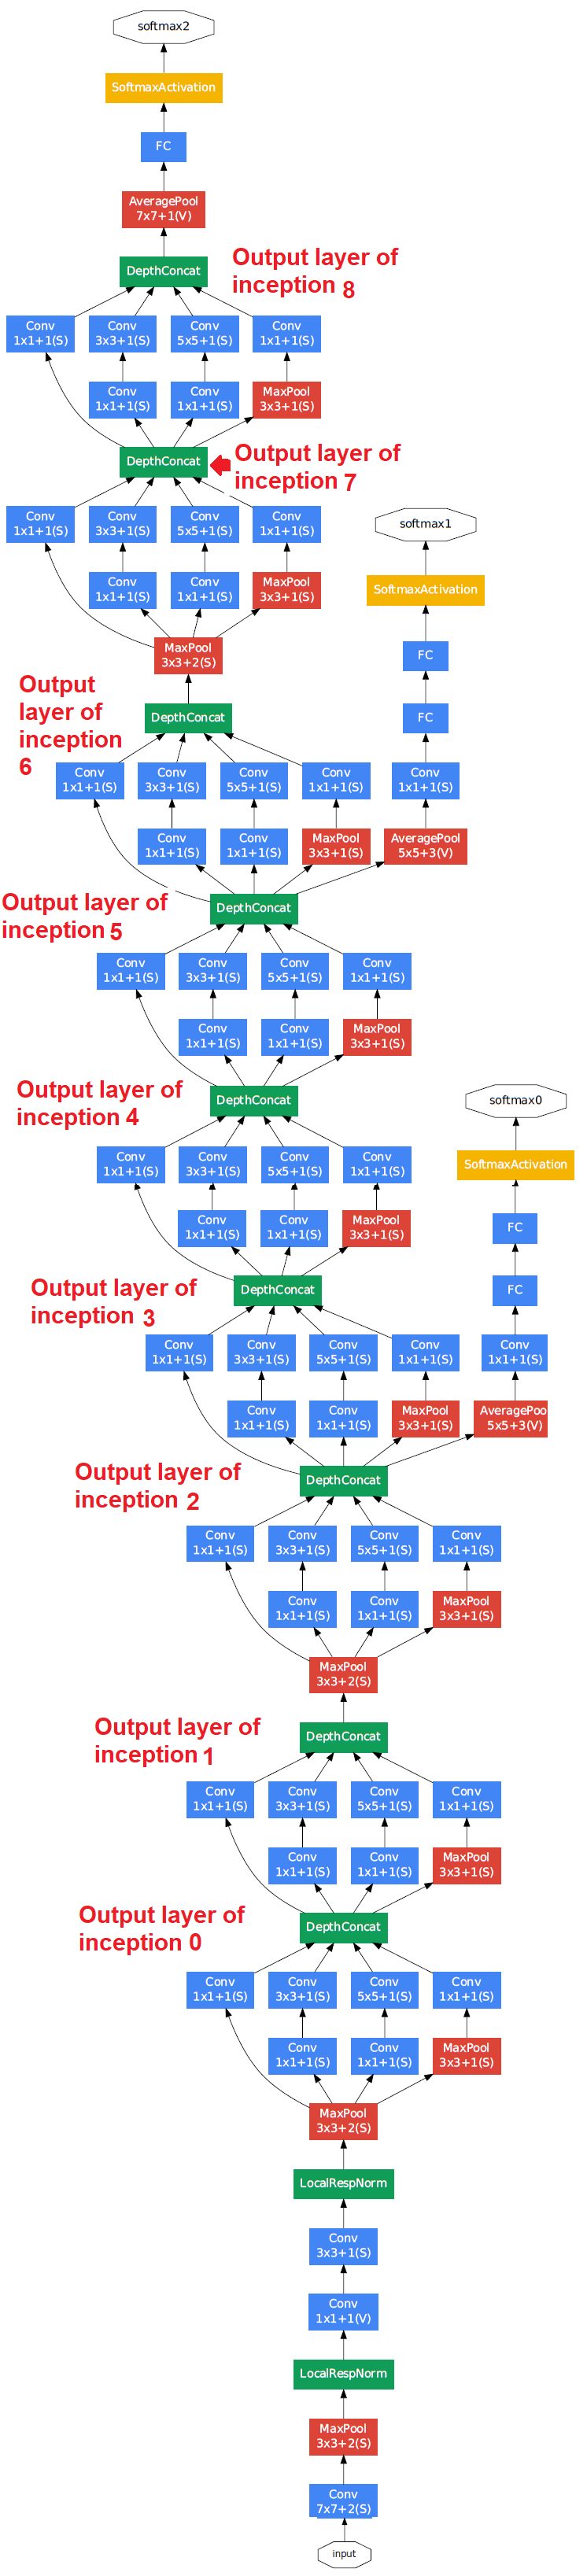

<p style = 'font-size:150%'>Notice that  auxiliary clasffifier 0 after inception 2 and<br>
auxiliary clasffifier 1 after inception 5.
</p>

<p id ="implementing_inception" style="font-size:200%">Implementing inception block.</p>

Inception module with dimensionality reduction will be implemented as a function that returns model.
each inception have 4 paths.
first path : --> have 1 convoultion layer filtersize of this layer are labels as (#1 X 1) 

second path : --> have 2 stacked convoultion layers filter size of first layer labels as (#3x3 reduce) and second layer labeled as (#3x3)

third path : --> have 2 stacked convoultion layers filter size of first layer labels as (#5x5 reduce) and second layer labeled as (#5x5)

fouth path : --> have 2 stacked layers first one is 3x3 max pooling and second one is 1x1 convolution 
filtersize of convoluted 

as mentioned at paper each all layer have relu activation function except fully connected layers and padding is same size





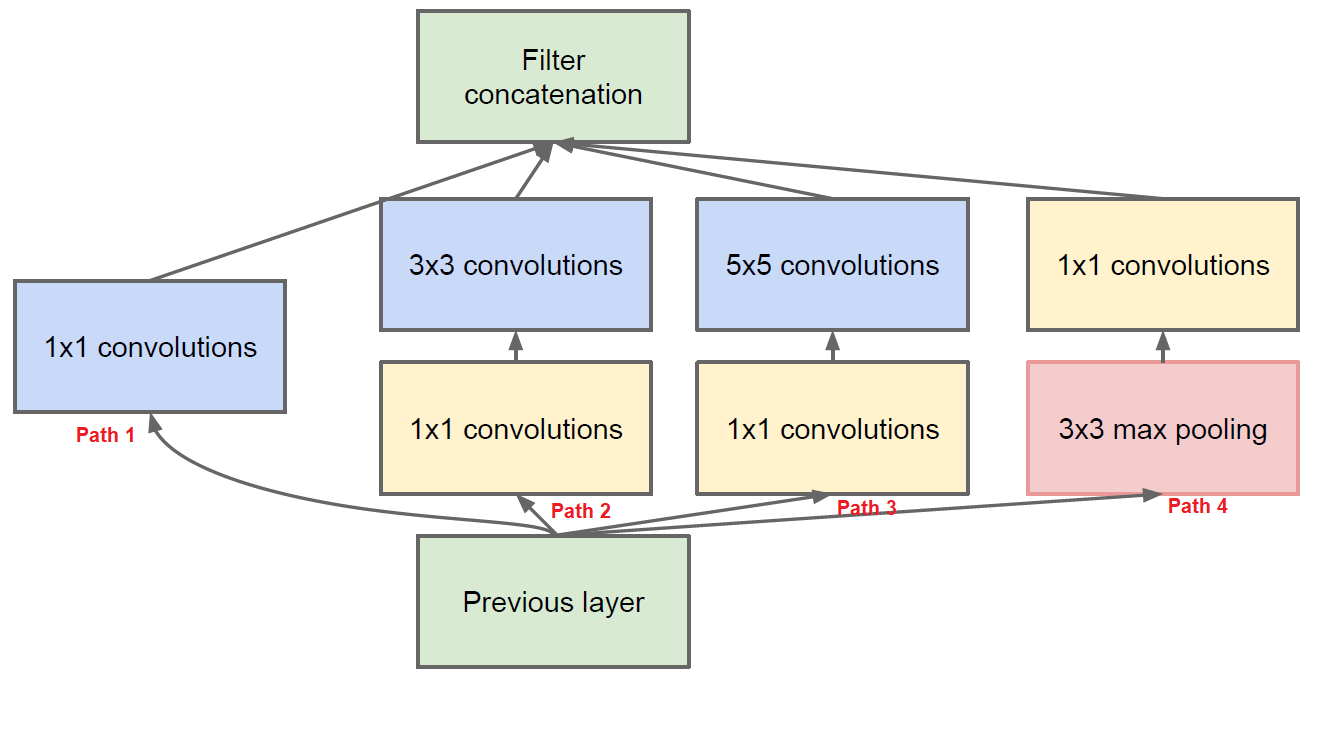

In [ ]:
def inception(previous_layer, filter_1x1, filters_3x3,filters_5x5, filter_pool_proj):
  #Path 1
  conv_1x1 = Conv2D(filter_1x1, kernel_size=1, padding='same', activation='relu')(previous_layer)

  #Path 2
  conv_3x3 = Conv2D(filters_3x3[0], kernel_size=1, padding='same', activation='relu')(previous_layer)
  conv_3x3 = Conv2D(filters_3x3[1], kernel_size=3, padding='same', activation='relu')(conv_3x3)

  #Path 3
  conv_5x5 = Conv2D(filters_5x5[0], kernel_size=1, padding='same', activation='relu')(previous_layer)
  conv_5x5 = Conv2D(filters_5x5[1], kernel_size=5, padding='same', activation='relu')(conv_5x5)

  #Path 4
  pool_proj = MaxPool2D(pool_size=(3, 3) ,padding='same',strides=(1, 1))(previous_layer) # pool_size = (3, 3) as mentioned at paper.
  pool_proj =  Conv2D(filter_pool_proj, kernel_size=1, padding='same', activation='relu')(pool_proj)
  #Filter concatenation
  filter_concatenation = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj])
  return filter_concatenation

<p id ="Inception_architecture" style="font-size:200%">GoogLeNet incarnation of the Inception architecture.</p>


<p style='fone-size:125%'>
Although it's mentioned at this paper that inception depth is 2, I reduced it to one in order to avoid the problem of vanishing gradient and to reduce trainable weights. <br>
Note the I found that for this application decreasing deoth of inception , output higher accuracy. 
</p>

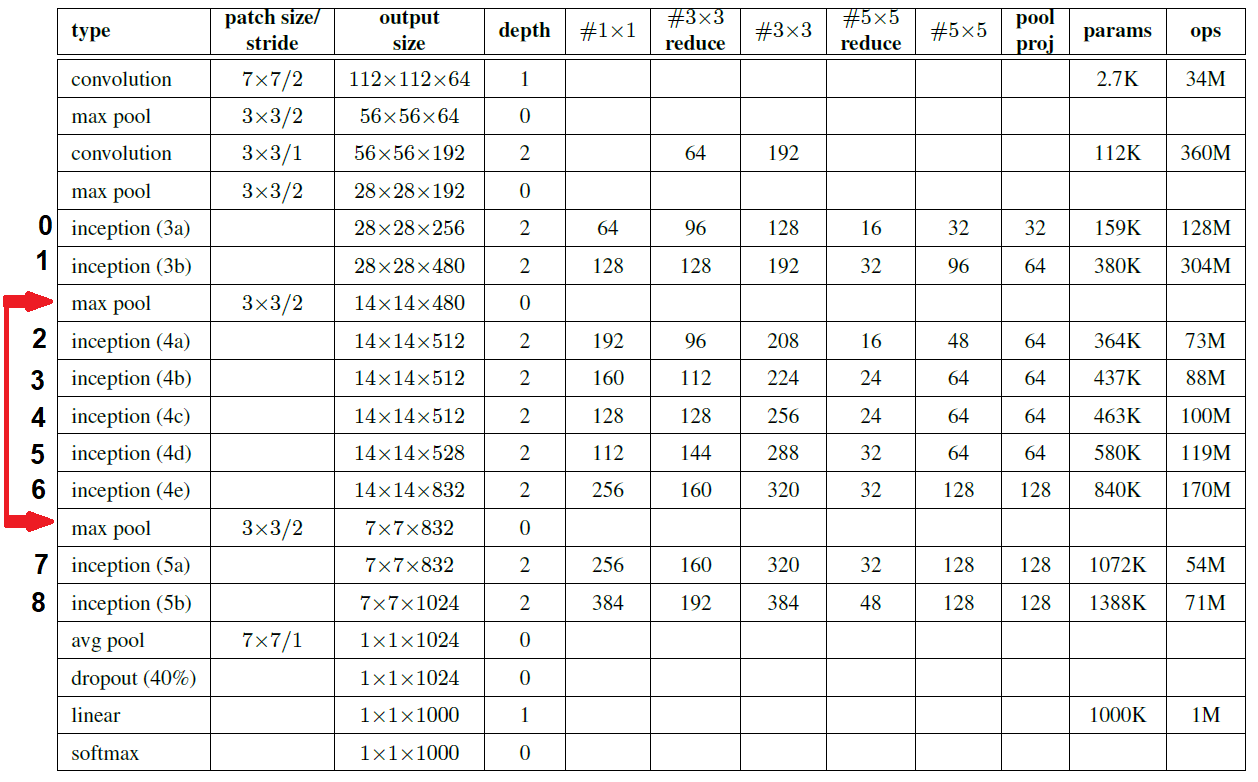

<p>
We deduce that<br>
    first layer has convolution kernel size is 7x7 and stride is 2<br>
    second layer has maxpooling kernel size is 3x3 and stride is 2<br>
    third layer has maxpooling kernel size is 3x3 and stride is 1<br>
    fourth layer has maxpooling kernel size is 3x3 and stride is 2<br> <br>
    
    <p style="font-size:115%;color:blue" > Fourth layer we can use stacked inception layer but after inception (3b) and inception (4e) , there is max pool layer kernel size is 3x3 and stride is 2.<p>
    
</p>

In [ ]:
'''
first element contains #1x1 filter
second element contains (#3x3 reduced) filter size and (#3x3)
third element containd (#5x5 reduced) filter size and (#5x5)
for example inception 3a (block 0)
(64, (96, 128), (16, 32), 32)
'''
inception_filtersSize = [(64, (96, 128), (16, 32), 32) ,    #block 0
                         (128, (128, 192), (32, 96), 64),   #block 1
                         (192, (96, 208), (16, 48), 64),    #block 2  
                         (160, (112, 224), (24, 64), 64),   #block 3
                         (128, (128, 256), (24, 64), 64),   #block 4
                         (112, (144, 288), (32, 64), 64),   #block 5
                         (256, (160, 320), (32, 128), 128), #block 6
                         (256, (160, 320), (32, 128), 128), #block 7
                         (384, (192, 384), (48, 128), 128)] #block 8

<p id ="Aux_network" style="font-size:200%">Auxiliary Network.</p>


Structure of auxiliary network.
<ul>
<li>An average pooling layer with 5x5 filter size and stride 3.</li>
<li>A 1x1 convolution with 128 filters for dimension reduction and rectified linear activation.</li>
<li>A fully connected layer with 1024 units and rectified linear activation.</li>
<li>A dropout layer with 70% ratio of dropped outputs</li>
</ul>

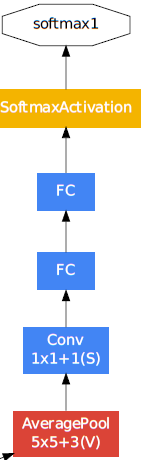

In [ ]:
def auxilliary_network(X, name):
  X = AveragePooling2D((5, 5), strides=(3, 3))(X)
  X = Conv2D(128, (1, 1), padding='same',activation='relu')(X)
  X = Flatten()(X)
  X = Dense(1024, activation='relu')(X)
  X = Dropout(.7)(X)
  X = Dense(4, activation='softmax', name=name)(X)
  return X

<p id ="implement_G_NN" style="font-size:200%">Implement GoogLeNet</p>


In [ ]:
input_layer = Input(shape=(480, 640, 3))
layer = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
layer = MaxPool2D(pool_size=(3, 3),strides=(2, 2), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(64, kernel_size=(3, 3),padding='same' , activation='relu')(layer)
layer = Conv2D(192, kernel_size=(3, 3),padding='same' , activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = MaxPool2D(pool_size=(3, 3), strides=(2, 2),padding='same')(layer)
for block, layer_filterSize in enumerate(inception_filtersSize):
  layer = inception(layer, *layer_filterSize)
  if block == 1 or block == 6 : # as mentioned above max booling after inception block 1 and 6
        layer = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)
  if block == 2: # as mentioned above aux_classifier0 after inception block 2
    aux_0 = auxilliary_network(layer, 'aux_0')    
  if block == 5:# as mentioned above aux_classifier1 after inception block 5
    aux_1 = auxilliary_network(layer,'aux_1') 
layer = AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(layer)
layer = Dropout(.6)(layer)
layer = Flatten()(layer)

out_layer = Dense(4, activation='softmax', name='main')(layer)
GoogLeNet_model = Model(input_layer, [out_layer, aux_0, aux_1])


<p id ="train_google_NN" style="font-size:200%">Training GoogLeNet Model </p>


In [ ]:
batch_size = 32 ; epochs = 30

GoogLeNet_bestWeights = save_bestWeights('val_main_accuracy') #save weights for higher validation accuracy.
GoogLeNet_model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              loss_weights = [1, 0.3, .3], optimizer='adam', metrics=['accuracy'])

history = GoogLeNet_model.fit(dataGenerator(multiple_output=True),steps_per_epoch = len(X_train)//batch_size+1,
                              validation_data=(X_val, [y_val, y_val, y_val]), epochs = epochs,
                              callbacks=[GoogLeNet_bestWeights])

weights = GoogLeNet_bestWeights.get_bestWeights()
GoogLeNet_model.set_weights(weights) 


<p id ="plt_aux0">Plotting Auxiliary Network 0 accuracy and loss function during training.</p>

In [ ]:
plot('Aux 0', (history.history['aux_0_loss'], history.history['val_aux_0_loss']),(
      history.history['aux_0_accuracy'], history.history['val_aux_0_accuracy'] ))

<p id ="plt_aux1">Plotting Auxiliary Network 1 accuracy and loss function during training.</p>

In [ ]:
plot('Aux 1', (history.history['aux_1_loss'], history.history['val_aux_1_loss']),(
      history.history['aux_1_accuracy'], history.history['val_aux_1_accuracy'] ))

<p id ="plt_main">Plotting Main Network accuracy and loss function during training.</p>

In [ ]:
plot('Main', (history.history['main_loss'], history.history['val_main_loss']),(
      history.history['main_accuracy'], history.history['val_main_accuracy'] ))

<p id ="resnet" style="font-size:200%">ResNet.</p>

won the 1st place on the
ILSVRC 2015 classification task.

[ResNet paper](https://arxiv.org/abs/1512.03385)

It solved the problem of vanishing gradient - It is a problem where the gradient become small so it prevents the weight from updating it's value - by reformulating layers as learning
residual functions with reference to the layer inputs, instead
of learning unreferenced functions.


Resnet paper proposes 18, 34, 50, 101, 152 layers for resnet. Through this notebook we will use 50 layers type.

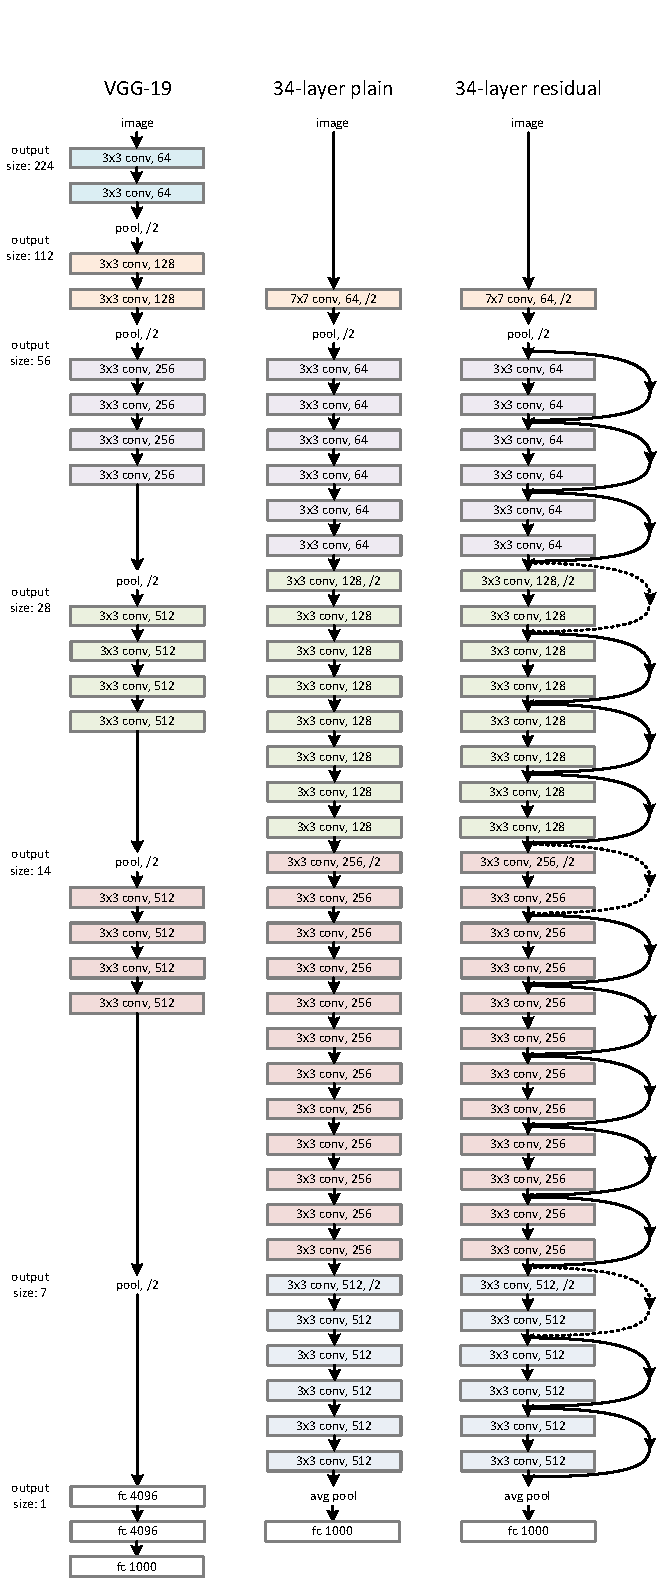

<p id ="skip_connection" style="font-size:200%">Skip Connection.</p>
It is the strength of ResNet which solved the problem of vanishing gradient for deep neural networks. It connects the output of one layer with the input of an earlier layer.

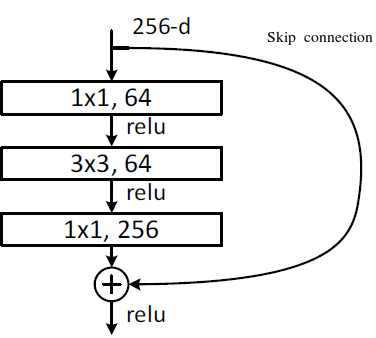

<p>Resnet block with skip connection<br>
are 1x1, 3x3, and 1x1 convolutions, where the 1x1 layers<br>
are responsible for reducing and then increasing (restoring)<br>
dimensions, leaving the 3x3 layer a bottleneck with smaller<br>
input/output dimensions.</p>

<p id ="arc_table" style="font-size:200%">Architecture table for building block.</p>

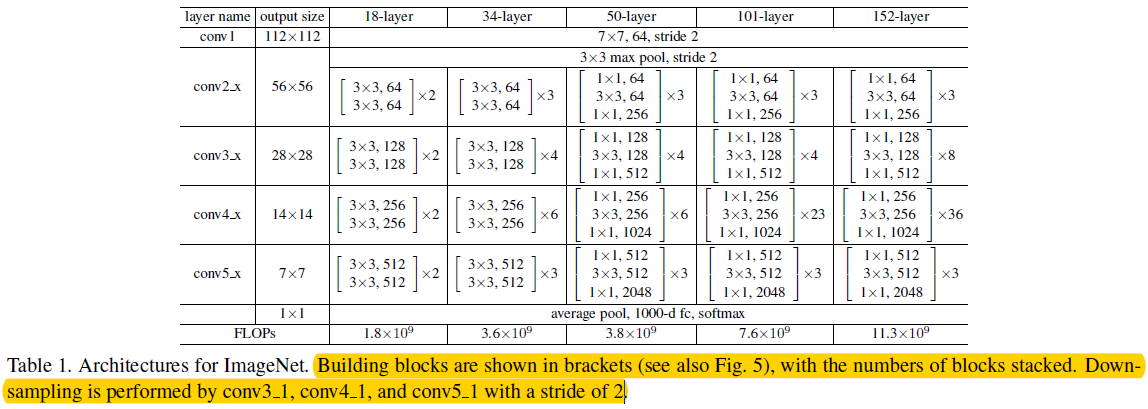

<p>
We deduce that.<br>
Conv 1 layer has 1 Convolution number of filters is 64 and kernel size for each filter is 7x7 and stride is 2x2.<br>
    then there is max pooling size is 3x3 and stride is (2x2).<br>
We notice that from Convolution 2 to 5 . layers have a paatern of
    <ol>
        <li>each block has a layer of 1x1 then 1x1 finally 3x4</li>
        <li>first block has a depth of 3, second has 4 third has 6, fourth has 3.</li>
        <li>for each block we can create a list for each filter size</li>
       </ol>
     so we can create a python dictionary to save the hyperparameters for each layer<br>
     keys for this dictionary is number of block<br>
     values of this dictionary is a dictionaty of depth and list of filter size
    
</p>

<p id ="resnet_implementation" style="font-size:200%">Resnet50 implementation</p>

In [ ]:
Resnet_50Architecture = { 2 : {'filter':[64, 64, 256], 'depth':3},
    3 : {'filter':[128, 128, 512], 'depth':4},
    4 : {'filter':[256, 256, 1024], 'depth':6},
    5 : {'filter':[512, 512, 2048], 'depth':3}
}

In [ ]:
def building_block(layer, filters,block_number, x):
  layer_shortcut = layer
  if block_number > 2 and x == 1:
    s = 2
  else:
    s = 1 
  if x == 1:
    layer_shortcut = Conv2D(filters[-1], kernel_size=(1, 1),strides=(s, s), padding='valid')(layer_shortcut)
    layer_shortcut = BatchNormalization()(layer_shortcut)

  layer = Conv2D(filters[0],kernel_size= (1, 1), strides =(s, s))(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)

  layer = Conv2D(filters[1],kernel_size= (3, 3),  padding = 'same')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)

  layer = Conv2D(filters[2],kernel_size= (1, 1))(layer)
  layer = BatchNormalization()(layer)

  layer = Add()([layer, layer_shortcut]) #Noticeskip connection.
  layer = Activation('relu')(layer)

  return layer
  

In [ ]:
def ResNet(input_shape, classes, architecture):
  input_layer = Input(shape=input_shape)
  layer = ZeroPadding2D((3, 3))(input_layer)
  layer = Conv2D(64, (7, 7), strides=(2, 2))(layer)
  layer = BatchNormalization(axis=3)(layer)
  layer = Activation('relu')(layer)
  layer = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(layer)

  for block in range(2, 6):
    for i in range(1, architecture[block]['depth']+1):
      layer = building_block(layer, architecture[block]['filter'],block, i)     
  layer = AveragePooling2D((2,2))(layer)  
  layer = Flatten()(layer)
  layer = Dense(classes, activation='softmax')(layer)

  model = Model(inputs = input_layer, outputs = layer)
  return model

renet50_model = ResNet(input_shape = (480, 640, 3), classes = 4, architecture = Resnet_50Architecture)

<p id ="resnet_training" style="font-size:200%">ResNet training</p>

In [ ]:
batch_size = 16 ; epochs = 20

resnet50_bestWeights = save_bestWeights('val_accuracy')
renet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = renet50_model.fit(dataGenerator(),steps_per_epoch = len(X_train)//batch_size+1,
                              validation_data=(X_val, y_val), epochs = epochs,
                              callbacks=[resnet50_bestWeights])

weights = resnet50_bestWeights.get_bestWeights()
renet50_model.set_weights(weights)


<p id ="resnet_trainingplt" style="font-size:100%">Plotting resnet during training.</p>

In [ ]:
plot('Main', (history.history['loss'], history.history['val_loss']),(
      history.history['accuracy'], history.history['val_accuracy'] ))

<p id ="load_prediction" style="font-size:200%">Load prediction data.</p>

In [ ]:
X_prediction = list()
for i in range(0,1821):
  img = cv2.imread(f'/kaggle/input/plant-pathology-2020-fgvc7/images/Test_{i}.jpg')
  if img.shape[0] > img.shape[1]:
        img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  img = cv2.resize(img, (640, 480))
  X_prediction.append(cv2.imencode('.jpg', img)[1])

In [ ]:
def data_predictGenerator(data, batch): 
  for i in range(len(data)//batch+1):
    img = data[i*batch: (i+1)*batch]
    img = list(map(deCode, img))
    img = np.array(img)
    img = img.astype('float32')/255
    yield img

<p id ="prediction_google" style="font-size:200%">Google Net prediction.</p>

In [ ]:
batch = 32
GoogLeNet_prediction = GoogLeNet_model.predict_generator(data_predictGenerator(X_prediction, batch),steps=(len(X_prediction)//batch)+1, verbose=1)
GoogLeNet_prediction = GoogLeNet_prediction[0] + GoogLeNet_prediction[1] + GoogLeNet_prediction[2]
GoogLeNet_prediction /= 3
GoogLeNet_sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
GoogLeNet_sub.iloc[:,1:] = GoogLeNet_prediction
GoogLeNet_sub.to_csv('googleNet_submission.csv', index=False)
GoogLeNet_sub.head()

<p id ="prediction_resnet" style="font-size:200%">ResNet prediction.</p>

In [ ]:
batch = 32
resNet_prediction = renet50_model.predict_generator(data_predictGenerator(X_prediction, batch),steps=(len(X_prediction)//batch)+1, verbose=1)
resNet = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
resNet.iloc[:,1:] = resNet_prediction
resNet.to_csv('resNet_submission.csv', index=False)
resNet.head()

<p id ="ensemble" style="font-size:200%">Ensemble.</p>

In [ ]:
prediction = .5*resNet_prediction + .5*GoogLeNet_prediction
sample_sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
sample_sub.iloc[:,1:] = prediction
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()